### This script is used for comparing WTC11 PB9 and WTC11 recombinase screens consistency. 

In [1]:
#!/usr/bin/env python3
import os
import re
import sys
import collections
import argparse
import tables
import glob
import itertools
import math

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sp_sparse

import matplotlib.gridspec as gridspec
from multiprocessing import Pool
from collections import defaultdict
from scipy import sparse, io
from scipy.sparse import csr_matrix
from multiprocessing import Pool
import matplotlib.pyplot as plt
import gseapy as gp

#### local fold change: filter hits and compare fold change 

In [2]:
PB9_DIR = '/project/GCRB/Hon_lab/s426305/Analysis/IGVF/20240605_WTC11_CMPilot2_PB9/pySpade/'
recomb_DIR = '/project/GCRB/Hon_lab/s426305/Analysis/IGVF/20241022_WTC11_recombinase_CMPilot2/pySpade/'

In [3]:
annot_dict_file = '/project/GCRB/Hon_lab/s426305/Analysis/IGVF/20231027_CMPilot2_lenti_cleancell/pySpade/perturbation_region_annot.txt'
annot_dict = {}
with open(annot_dict_file) as f:
    for line in f:
        region_id, annotation = line.strip().split("\t")
        annot_dict.update({region_id : annotation})

#### PB9

In [4]:
PB9_local_hit_df = pd.read_csv(PB9_DIR + 'WTC11_CMPilot2_PB9_local.csv', index_col=0)

In [5]:
PB9_express_df = pd.read_csv(PB9_DIR + 'filtered_local.csv', index_col=0)

#### recombinase

In [6]:
recomb_local_hit_df = pd.read_csv(recomb_DIR + 'unfiltered_local_df.csv', index_col=0)

In [7]:
recomb_express_df = pd.read_csv(recomb_DIR + 'filtered_local.csv', index_col=0)

### Consider all the potential hits

In [8]:
recomb_express_df['combined'] = recomb_express_df['gene_names'] + '_' + recomb_express_df['region']
PB9_express_df['combined'] = PB9_express_df['gene_names'] + '_' + PB9_express_df['region']

In [9]:
all_local_hits_region = list(set(recomb_express_df['combined']).union(set(PB9_express_df['combined'])))

In [10]:
recomb_local_hit_df['combined'] = recomb_local_hit_df['gene_names'] + '_' + recomb_local_hit_df['region']
PB9_local_hit_df['combined'] = PB9_local_hit_df['gene_names'] + '_' + PB9_local_hit_df['region']

In [11]:
len(all_local_hits_region)

77

In [12]:
x = [] 
y = []
for hits in all_local_hits_region:
    a, _ = recomb_local_hit_df[recomb_local_hit_df['combined'] == hits].shape
    b, _ = PB9_local_hit_df[PB9_local_hit_df['combined'] == hits].shape
    if (a==0) or (b==0):
        print(hits)
        continue
    else:
        x_val = recomb_local_hit_df[recomb_local_hit_df['combined'] == hits]['fc_by_rand_dist_cpm'].values[0]
        y_val = PB9_local_hit_df[PB9_local_hit_df['combined'] == hits]['fc_by_rand_dist_cpm'].values[0]
        x.append(x_val)
        y.append(y_val)

SOX17_chr8:54457434-54458434
NR5A2_chr1:201377200-201378200


In [13]:
len(x)

75

In [14]:
len(y)

75

In [15]:
all_local_hits_region.remove('NR5A2_chr1:201377200-201378200')
all_local_hits_region.remove('SOX17_chr8:54457434-54458434')

In [16]:
len(all_local_hits_region)

75

In [17]:
label_list = []
for name in all_local_hits_region:
    gene = name.split('_')[0]
    region = name.split('_')[1]
    annot = annot_dict[region]
    if len(annot.split('_')) < 2:
        label = gene + '_enhancer'
        label_list.append(label)
    else:
        if annot.split('_')[1].startswith('PROM'):
            pred_gene = annot.split('_')[0]
            if gene == pred_gene:
                label = gene +'_promoter'
            else:
                label = gene + '_enhancer'
        elif annot.split('_')[1].startswith('ENH'):
            label = gene + '_enhancer'
        else:
            label = gene + '_enhancer'
        label_list.append(label)

In [18]:
len(x)

75

In [19]:
len(label_list)

75

In [20]:
promoter_index = []
enhancer_index = []
for index, label in enumerate(label_list):
    if label.split('_')[1] == 'promoter':
        promoter_index.append(index)
    else:
        enhancer_index.append(index)

In [21]:
res = stats.linregress(np.array([(1-i)*100 for i in x])[promoter_index], np.array([(1-i)*100 for i in y])[promoter_index])

In [22]:
res

LinregressResult(slope=0.8297777371712337, intercept=19.83757403200903, rvalue=0.8669310399066256, pvalue=9.765741764553e-17, stderr=0.06746751949988852, intercept_stderr=4.058435620626534)

In [23]:
print(f"R-squared: {res.rvalue**2:.6f}")

R-squared: 0.751569


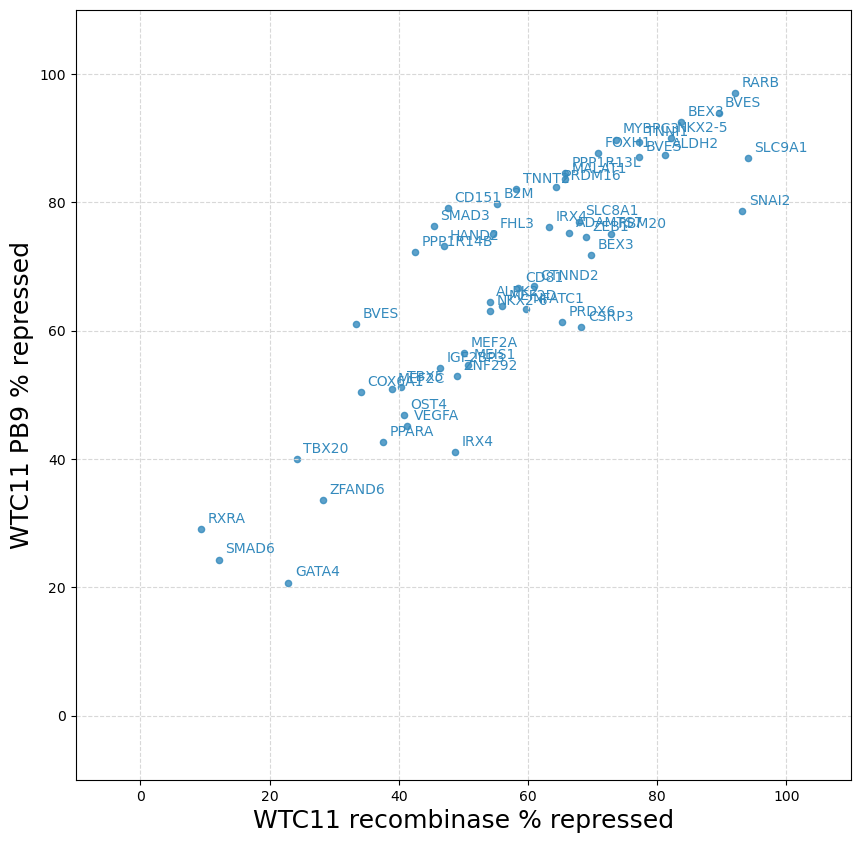

In [25]:
fig, ax = plt.subplots(figsize= (10,10))
ax.set_xlim(-10,110)
ax.set_ylim(-10,110)
[ymin, ymax] = [0, 100]
[xmin, xmax] = [0, 100]

ax.set_ylabel('WTC11 PB9 % repressed', fontsize=18)
ax.set_xlabel('WTC11 recombinase % repressed', fontsize=18)
ax.grid(ls='--', color='#D8D8D8')
#Plot promoter
ax = plt.scatter(np.array([(1-i)*100 for i in x])[promoter_index], np.array([(1-i)*100 for i in y])[promoter_index], s=20, c='#348ABD', alpha=0.8)
for i, txt in enumerate(np.array(label_list)[promoter_index]):
    plt.annotate(txt.split('_')[0], (np.array([(1-i)*100 for i in x])[promoter_index][i]+(xmax*0.01), np.array([(1-i)*100 for i in y])[promoter_index][i]+(ymax*0.01)), fontsize=10, color='#348ABD')

#plt.show()
plt.savefig('./WTC11_newrecombinase_PB9_promoter_local_fc_scatter_ver4.pdf')

In [26]:
res = stats.linregress(np.array([(1-i)*100 for i in x])[enhancer_index], np.array([(1-i)*100 for i in y])[enhancer_index])

In [27]:
res

LinregressResult(slope=0.9128001166273717, intercept=11.629720355767171, rvalue=0.8697168450619736, pvalue=7.085307103024281e-08, stderr=0.11303689297119768, intercept_stderr=8.476365357366191)

In [28]:
print(f"R-squared: {res.rvalue**2:.6f}")

R-squared: 0.756407


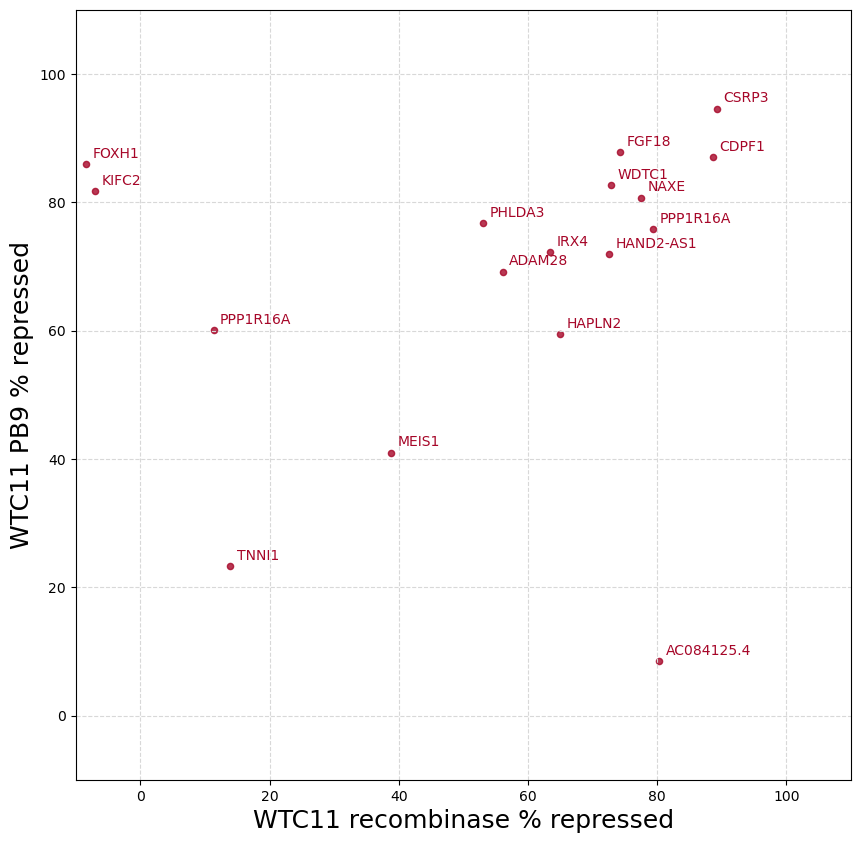

In [31]:
fig, ax = plt.subplots(figsize= (10,10))
ax.set_xlim(-10,110)
ax.set_ylim(-10,110)
#[xmin, xmax] = [0, 100]

ax.set_ylabel('WTC11 PB9 % repressed', fontsize=18)
ax.set_xlabel('WTC11 recombinase % repressed', fontsize=18)
ax.grid(ls='--', color='#D8D8D8')
#Plot enhancer
ax = plt.scatter(np.array([(1-i)*100 for i in x])[enhancer_index], np.array([(1-i)*100 for i in y])[enhancer_index], s=20, c='#A60628', alpha=0.8)
for i, txt in enumerate(np.array(label_list)[enhancer_index]):
    plt.annotate(txt.split('_')[0], (np.array([(1-i)*100 for i in x])[enhancer_index][i]+(xmax*0.01), np.array([(1-i)*100 for i in y])[enhancer_index][i]+(ymax*0.01)), fontsize=10, color='#A60628')

#plt.show()
plt.savefig('./WTC11_newrecomb_PB9_enhancer_local_fc_scatter_ver4.pdf')